In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
path = os.path.join(os.getcwd(), os.pardir)
sys.path.append(path)

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew, mode
from sklearn import metrics
import matplotlib.pyplot as plt
import pylab as py
from BAI import environment, solver, analysis

In [3]:
plt.rcParams['figure.figsize'] = [10, 6]

# Utilities

In [4]:
# http://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
# https://chart-studio.plotly.com/~david_avakian/14.embed
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

def bc2xy(bc_coords, tol=1.e-4):
    '''Converts barycentric to 2D Cartesian coordinates'''
    bc_coords = np.clip(bc_coords, tol, 1.0 - tol)
    xy_coords = corners.T.dot(bc_coords)
    return xy_coords

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

In [5]:
def draw_pdf_contours(dist, nlevels=200, subdiv=8, samples=None,**kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.colorbar()
    plt.axis('off')
    plt.title(r'Distribution of $(\alpha_1,\alpha_2,\alpha_3)$', fontsize=25, usetex = True);
    plt.text(-0.06, 0.01, r'$\alpha_1$', fontsize=20);
    plt.text(1.0, 0.01, r'$\alpha_2$', fontsize=20);
    plt.text(0.52, 0.83, r'$\alpha_3$', fontsize=20);

    if samples is not None:
        points = np.array([bc2xy(bc) for bc in samples])
        plt.scatter(points[:,0], points[:,1], alpha=0.2, s=1, c='grey');

In [6]:
def draw_sample_contours(dist, nlevels=200, subdiv=8, samples=None,**kwargs):
    import math

    plt.plot((0, 0.5), (0, 0.87), marker = 'o', color='black')
    plt.plot((0, 1), (0, 0), marker = 'o', color='black')
    plt.plot((1, 0.5), (0, 0.87), marker = 'o', color='black')

    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    # plt.colorbar()
    plt.axis('off')
    plt.title(r'Distribution of $(\alpha_1,\alpha_2,\alpha_3)$', fontsize=25, usetex = True);
    plt.text(-0.06, 0.01, r'$\alpha_1$', fontsize=20);
    plt.text(1.0, 0.01, r'$\alpha_2$', fontsize=20);
    plt.text(0.52, 0.83, r'$\alpha_3$', fontsize=20);

    if samples is not None:
        points = np.array([bc2xy(bc) for bc in samples])
        plt.scatter(points[:,0], points[:,1], alpha=1, s=1, c='grey');

# Simulation Setup

In [29]:
K = 3
K_H0 = 2
gamma = 0.01
n_parallels = 100000
n_batches = 20
batch_func = environment.func_constant_batch(300)
variance = [1 for i in range(K)]

thetas = [0.25, 0.25, 0]
reward_func_null = environment.func_gaussian_reward(thetas, variance)
bandit_null = environment.Bandit(K=K, reward_func=reward_func_null, batch_func=batch_func)

bandit = bandit_null

In [8]:
eta = 1

# UNIF

In [9]:
G = 5000
beta = 0.5
tracking_history = []
for parallel_idx in range(n_parallels):
    null_vs_alter = 0
    
    trials = [0 for i in range(K)]
    rewards = [0 for i in range(K)]
    mus_nb = [0 for i in range(K)]
    mus_wb = [0 for i in range(K)]
    lambdas = [0 for i in range(K)]
    numerator = [0 for i in range(K)]
    denominator = [0 for i in range(K)]
    batch_count = [0 for i in range(K)]
    # cal sample variance
    SS = [0 for _ in range(K)]
    sample_variance_nb = [1 for _ in range(K)]
    sample_variance_wb = [1 for _ in range(K)]
    sampling_probs = [1 / K for i in range(K)]
    for batch_idx in range(n_batches):
        batch_feedback = bandit.batch_observe_fast(
            sampling_distrib = sampling_probs, 
            time_index=batch_idx
        )
        for arm_idx in range(K):
            batch_trials = batch_feedback['trials'][arm_idx]
            if batch_trials > 0:
                trials[arm_idx] += batch_trials
                rewards[arm_idx] += batch_feedback['rewards'][arm_idx]
                # update batch info
                batch_count[arm_idx] += 1
                denominator[arm_idx] += np.sqrt(batch_trials)
                numerator[arm_idx] += batch_feedback['rewards'][arm_idx] / np.sqrt(batch_trials)
                # initial prior by first batch or update posterior
                lambdas[arm_idx] =  denominator[arm_idx]**2 / batch_count[arm_idx]
                mus_wb[arm_idx] = numerator[arm_idx] / denominator[arm_idx]
                mus_nb[arm_idx] = rewards[arm_idx] / trials[arm_idx]
                # cal sample variance
                SS[arm_idx] += batch_feedback['squared_rewards'][arm_idx]
                sample_variance_nb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_nb[arm_idx]**2
                sample_variance_wb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_wb[arm_idx]**2
        # weighted batched
        mc_sampling = np.array([np.random.normal(mus_wb[i], np.sqrt(sample_variance_wb[i]/(eta * lambdas[i])), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        wb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        wb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # naive batched
        mc_sampling = np.array([np.random.normal(mus_nb[i], np.sqrt(sample_variance_nb[i]/(eta * trials[i])), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        nb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        nb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # tracking history and analysis
        for arm_idx in range(K):
            tracking_reccord = (
                parallel_idx,
                null_vs_alter,
                batch_idx,
                arm_idx,
                sampling_probs[arm_idx],
                mus_nb[arm_idx],
                trials[arm_idx],
                sample_variance_nb[arm_idx],
                nb_optimal_probs[arm_idx],
                nb_posterior_delta[arm_idx],
                mus_wb[arm_idx],
                lambdas[arm_idx],
                sample_variance_wb[arm_idx],
                wb_optimal_probs[arm_idx],
                wb_posterior_delta[arm_idx],
                trials[arm_idx] / sum(trials)
            )
            tracking_history.append(tracking_reccord)
        # change traffic
        # optimal_odds = [wb_optimal_probs[i] / (1 - wb_optimal_probs[i]) if wb_optimal_probs[i] < 1 else 99 for i in range(K)]
        # sampling_probs = [wb_optimal_probs[i] * (beta + (1 - beta) * (np.sum(optimal_odds) - optimal_odds[i])) for i in range(K)]
        # sampling_probs = [nb_optimal_probs[i] / np.sum(nb_optimal_probs) for i in range(K)]
        # sampling_probs = [(1 - gamma) * sampling_probs[i] + gamma * 1/K for i in range(K)]
# convert tracking_history to dataframe
df_UNIF = pd.DataFrame(tracking_history, columns=[
    'parallel_idx','null_vs_alter','batch_idx', 'arm_idx', 'sampling_prob', 
    'mu_nb', 'tau_nb', 'sample_variance_nb', 'optimal_prob_nb','posterior_delta_nb',
    'mu_wb', 'tau_wb', 'sample_variance_wb', 'optimal_prob_wb','posterior_delta_wb',
    'proportion_trials'
])

In [10]:
alpha_analysis = df_UNIF.groupby(['null_vs_alter', 'batch_idx']).apply(
    lambda x: pd.Series([
        np.mean(x.optimal_prob_wb[x.arm_idx == 0]),
        np.var(x.optimal_prob_wb[x.arm_idx == 0]),
        np.mean(x.optimal_prob_wb[x.arm_idx == 1]),
        np.var(x.optimal_prob_wb[x.arm_idx == 1]),
        np.mean(x.optimal_prob_wb[x.arm_idx == 2]),
        np.var(x.optimal_prob_wb[x.arm_idx == 2]),
    ])
).rename(columns={
    0:'mean_prob_1',1:'var_prob_1',
    2:'mean_prob_2',3:'var_prob_2',
    4:'mean_prob_3',5:'var_prob_3',
}).reset_index()

alpha_analysis['alpha_0'] = alpha_analysis.mean_prob_1 * (1 - alpha_analysis.mean_prob_1) / alpha_analysis.var_prob_1 - 1
alpha_analysis['alpha_1'] = alpha_analysis.mean_prob_1 * alpha_analysis.alpha_0
alpha_analysis['alpha_2'] = alpha_analysis.mean_prob_2 * alpha_analysis.alpha_0
alpha_analysis['alpha_3'] = alpha_analysis.mean_prob_3 * alpha_analysis.alpha_0

alpha_analysis

null_vs_alter  batch_idx  mean_prob_1  var_prob_1  mean_prob_2  \
0               0          0     0.404548    0.082464     0.405389   
1               0          1     0.426623    0.080333     0.427326   
2               0          2     0.441764    0.080241     0.441432   
3               0          3     0.452759    0.080409     0.451896   
4               0          4     0.460456    0.080646     0.460155   
5               0          5     0.466596    0.080929     0.466971   
6               0          6     0.471829    0.081137     0.471781   
7               0          7     0.476444    0.081341     0.475482   
8               0          8     0.479664    0.081615     0.479151   
9               0          9     0.483299    0.081784     0.481484   
10              0         10     0.485542    0.081842     0.484116   
11              0         11     0.487583    0.081985     0.486287   
12              0         12     0.489727    0.082133     0.487789   
13              0         13     0.491071    0.082300     0.489454   
14              0         14     0.492409    0.082506     0.490686   
15              0         15     0.493410    0.082401     0.491886   
16              0         16     0.494066    0.082596     0.493138   
17              0         17     0.495117    0.082700     0.493744   
18              0         18     0.496285    0.082775     0.494029   
19              0         19     0.497076    0.082782     0.494452   

    var_prob_2  mean_prob_3  var_prob_3   alpha_0   alpha_1   alpha_2  \
0     0.082733     0.190063    0.046529  1.921155  0.777199  0.778815   
1     0.080540     0.146051    0.033691  2.045032  0.872458  0.873895   
2     0.080139     0.116804    0.025852  2.073364  0.915938  0.915249   
3     0.080221     0.095345    0.020080  2.081335  0.942342  0.940547   
4     0.080573     0.079389    0.016116  2.080559  0.958005  0.957380   
5     0.080909     0.066433    0.012923  2.075351  0.968351  0.969129   
6     0.081077     0.056391    0.010582  2.071438  0.977364  0.977264   
7     0.081218     0.048074    0.008629  2.066656  0.984645  0.982658   
8     0.081567     0.041185    0.007150  2.058100  0.987196  0.986141   
9     0.081721     0.035217    0.005868  2.053430  0.992420  0.988695   
10    0.081856     0.030342    0.004835  2.052130  0.996396  0.993468   
11    0.082017     0.026130    0.003940  2.047439  0.998297  0.995643   
12    0.082176     0.022484    0.003226  2.042550  1.000292  0.996332   
13    0.082373     0.019475    0.002679  2.036705  1.000167  0.996874   
14    0.082574     0.016905    0.002220  2.029398  0.999294  0.995796   
15    0.082432     0.014704    0.001846  2.033404  1.003302  1.000203   
16    0.082655     0.012796    0.001531  2.026360  1.001156  0.999274   
17    0.082748     0.011139    0.001271  2.022701  1.001474  0.998696   
18    0.082809     0.009686    0.001058  2.020081  1.002536  0.997978   
19    0.082810     0.008473    0.000883  2.019886  1.004036  0.998736   

     alpha_3  
0   0.365141  
1   0.298679  
2   0.242178  
3   0.198446  
4   0.165173  
5   0.137872  
6   0.116810  
7   0.099353  
8   0.084763  
9   0.072316  
10  0.062266  
11  0.053499  
12  0.045925  
13  0.039664  
14  0.034307  
15  0.029899  
16  0.025930  
17  0.022531  
18  0.019567  
19  0.017114

[1.00403636 0.99873615 0.01711388]


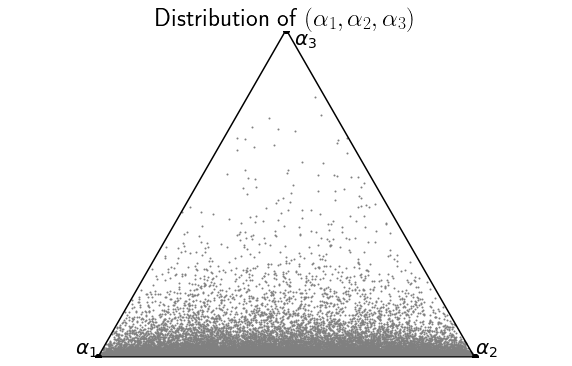

In [11]:
batch_idx = 19

alpha_1 = alpha_analysis.alpha_1.values
alpha_2 = alpha_analysis.alpha_2.values
alpha_3 = alpha_analysis.alpha_3.values
alpha = np.array([alpha_1[batch_idx],alpha_2[batch_idx],alpha_3[batch_idx]])
print(alpha)

sim_values = list(df_UNIF.query("batch_idx=={}".format(batch_idx)).groupby('parallel_idx').apply(lambda x: x.optimal_prob_wb.tolist()))

draw_sample_contours(Dirichlet(alpha), subdiv=4, samples=sim_values, alpha=0.8)

1.0040363632059601 1.0158500323700372


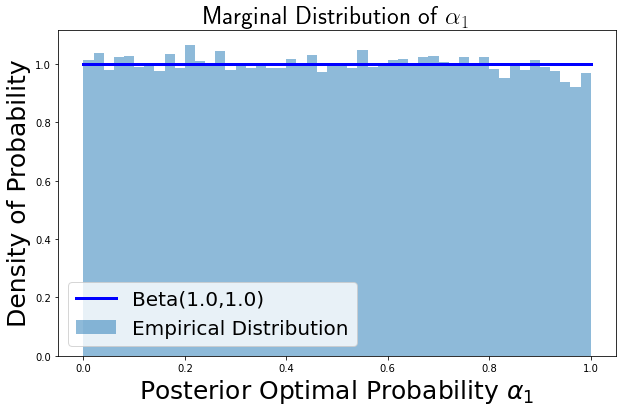

In [13]:
from scipy.stats import beta
# beta_a = alpha * (a0 - 2) + 1
beta_a = alpha[0]
beta_b = alpha[1]
print(beta_a, beta_b)

sim_values_0 = df_UNIF.query("arm_idx == 0 and batch_idx == {}".format(batch_idx)).optimal_prob_wb.values

plt.hist(sim_values_0, alpha=0.5, bins=50, density=True, label='Empirical Distribution');
x_values = np.linspace(0, 1, 1000)
plt.plot(x_values, beta.pdf(x_values, round(beta_a,1), round(beta_b, 1)), color='blue', alpha=1, lw=3, label=r'Beta({},{})'.format(round(beta_a,1), round(beta_b, 1)));

plt.title(r'Marginal Distribution of $\alpha_1$', fontsize=25, usetex = True);
plt.xlabel(r'Posterior Optimal Probability $\alpha_1$', fontsize=25);
plt.ylabel(r'Density of Probability', fontsize=25)
plt.legend(fontsize=20, loc='lower left')
# plt.legend(fontsize=20, loc='upper right')

# NBTS

In [30]:
G = 5000
beta = 0.5
tracking_history = []
for parallel_idx in range(n_parallels):
    bandit_choice = 0
    
    trials = [0 for i in range(K)]
    rewards = [0 for i in range(K)]
    mus_nb = [0 for i in range(K)]
    mus_wb = [0 for i in range(K)]
    lambdas = [0 for i in range(K)]
    numerator = [0 for i in range(K)]
    denominator = [0 for i in range(K)]
    batch_count = [0 for i in range(K)]
    # cal sample variance
    SS = [0 for _ in range(K)]
    sample_variance_nb = [1 for _ in range(K)]
    sample_variance_wb = [1 for _ in range(K)]
    sampling_probs = [1 / K for i in range(K)]
    for batch_idx in range(n_batches):
        batch_feedback = bandit.batch_observe_fast(
            sampling_distrib = sampling_probs, 
            time_index=batch_idx
        )
        for arm_idx in range(K):
            batch_trials = batch_feedback['trials'][arm_idx]
            if batch_trials > 0:
                trials[arm_idx] += batch_trials
                rewards[arm_idx] += batch_feedback['rewards'][arm_idx]
                # update batch info
                batch_count[arm_idx] += 1
                denominator[arm_idx] += np.sqrt(batch_trials)
                numerator[arm_idx] += batch_feedback['rewards'][arm_idx] / np.sqrt(batch_trials)
                # initial prior by first batch or update posterior
                lambdas[arm_idx] =  denominator[arm_idx]**2 / batch_count[arm_idx]
                mus_wb[arm_idx] = numerator[arm_idx] / denominator[arm_idx]
                mus_nb[arm_idx] = rewards[arm_idx] / trials[arm_idx]
                # cal sample variance
                SS[arm_idx] += batch_feedback['squared_rewards'][arm_idx]
                sample_variance_nb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_nb[arm_idx]**2
                sample_variance_wb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_wb[arm_idx]**2
        # weighted batched
        mc_sampling = np.array([np.random.normal(mus_wb[i], np.sqrt(sample_variance_wb[i]/(eta * lambdas[i])), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        wb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        wb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # naive batched
        mc_sampling = np.array([np.random.normal(mus_nb[i], np.sqrt(sample_variance_nb[i]/(eta * trials[i])), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        nb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        nb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # tracking history and analysis
        for arm_idx in range(K):
            tracking_reccord = (
                parallel_idx,
                null_vs_alter,
                batch_idx,
                arm_idx,
                sampling_probs[arm_idx],
                mus_nb[arm_idx],
                trials[arm_idx],
                sample_variance_nb[arm_idx],
                nb_optimal_probs[arm_idx],
                nb_posterior_delta[arm_idx],
                mus_wb[arm_idx],
                lambdas[arm_idx],
                sample_variance_wb[arm_idx],
                wb_optimal_probs[arm_idx],
                wb_posterior_delta[arm_idx],
                trials[arm_idx] / sum(trials)
            )
            tracking_history.append(tracking_reccord)
        # change traffic
        # optimal_odds = [wb_optimal_probs[i] / (1 - wb_optimal_probs[i]) if wb_optimal_probs[i] < 1 else 99 for i in range(K)]
        # sampling_probs = [wb_optimal_probs[i] * (beta + (1 - beta) * (np.sum(optimal_odds) - optimal_odds[i])) for i in range(K)]
        sampling_probs = [nb_optimal_probs[i] / np.sum(nb_optimal_probs) for i in range(K)]
        sampling_probs = [(1 - gamma) * sampling_probs[i] + gamma * 1/K for i in range(K)]
# convert tracking_history to dataframe
df_NBTS = pd.DataFrame(tracking_history, columns=[
    'parallel_idx','null_vs_alter','batch_idx', 'arm_idx', 'sampling_prob', 
    'mu_nb', 'tau_nb', 'sample_variance_nb', 'optimal_prob_nb','posterior_delta_nb',
    'mu_wb', 'tau_wb', 'sample_variance_wb', 'optimal_prob_wb','posterior_delta_wb',
    'proportion_trials'
])

In [31]:
alpha_analysis = df_NBTS.groupby(['null_vs_alter', 'batch_idx']).apply(
    lambda x: pd.Series([
        np.mean(x.optimal_prob_nb[x.arm_idx == 0]),
        np.var(x.optimal_prob_nb[x.arm_idx == 0]),
        np.mean(x.optimal_prob_nb[x.arm_idx == 1]),
        np.var(x.optimal_prob_nb[x.arm_idx == 1]),
        np.mean(x.optimal_prob_nb[x.arm_idx == 2]),
        np.var(x.optimal_prob_nb[x.arm_idx == 2]),
    ])
).rename(columns={
    0:'mean_prob_1',1:'var_prob_1',
    2:'mean_prob_2',3:'var_prob_2',
    4:'mean_prob_3',5:'var_prob_3',
}).reset_index()

alpha_analysis['alpha_0'] = alpha_analysis.mean_prob_1 * (1 - alpha_analysis.mean_prob_1) / alpha_analysis.var_prob_1 - 1
alpha_analysis['alpha_1'] = alpha_analysis.mean_prob_1 * alpha_analysis.alpha_0
alpha_analysis['alpha_2'] = alpha_analysis.mean_prob_2 * alpha_analysis.alpha_0
alpha_analysis['alpha_3'] = alpha_analysis.mean_prob_3 * alpha_analysis.alpha_0

alpha_analysis

null_vs_alter  batch_idx  mean_prob_1  var_prob_1  mean_prob_2  \
0               0          0     0.481941    0.082309     0.483362   
1               0          1     0.490667    0.086172     0.491603   
2               0          2     0.494322    0.090629     0.494220   
3               0          3     0.494737    0.093646     0.496704   
4               0          4     0.495621    0.095717     0.497465   
5               0          5     0.495934    0.097536     0.498299   
6               0          6     0.496542    0.098470     0.498458   
7               0          7     0.496775    0.099561     0.498812   
8               0          8     0.496655    0.100220     0.499408   
9               0          9     0.496999    0.101010     0.499460   
10              0         10     0.497465    0.101608     0.499301   
11              0         11     0.497692    0.102074     0.499346   
12              0         12     0.497835    0.102369     0.499424   
13              0         13     0.497896    0.102773     0.499578   
14              0         14     0.497728    0.103109     0.499937   
15              0         15     0.498053    0.103477     0.499756   
16              0         16     0.497910    0.103687     0.500042   
17              0         17     0.497859    0.103855     0.500212   
18              0         18     0.498182    0.104006     0.500007   
19              0         19     0.498610    0.104179     0.499687   

    var_prob_2  mean_prob_3  var_prob_3   alpha_0   alpha_1   alpha_2  \
0     0.082445     0.034697    0.005749  2.033361  0.979960  0.982849   
1     0.086213     0.017729    0.001575  1.900155  0.932344  0.934122   
2     0.090635     0.011458    0.000618  1.758130  0.869082  0.868904   
3     0.093682     0.008559    0.000337  1.669345  0.825887  0.829170   
4     0.095736     0.006915    0.000211  1.611663  0.798773  0.801745   
5     0.097560     0.005767    0.000140  1.562974  0.775132  0.778828   
6     0.098487     0.004999    0.000105  1.538731  0.764045  0.766993   
7     0.099569     0.004413    0.000082  1.510908  0.750582  0.753659   
8     0.100230     0.003937    0.000064  1.494401  0.742202  0.746316   
9     0.101022     0.003541    0.000051  1.474924  0.733035  0.736665   
10    0.101617     0.003234    0.000044  1.460376  0.726486  0.729168   
11    0.102080     0.002962    0.000036  1.449153  0.721232  0.723629   
12    0.102379     0.002741    0.000031  1.442109  0.717932  0.720224   
13    0.102777     0.002526    0.000027  1.432513  0.713243  0.715652   
14    0.103103     0.002335    0.000023  1.424558  0.709042  0.712189   
15    0.103471     0.002191    0.000021  1.415956  0.705221  0.707633   
16    0.103682     0.002048    0.000018  1.411055  0.702578  0.705587   
17    0.103846     0.001929    0.000017  1.407150  0.700562  0.703873   
18    0.103999     0.001811    0.000015  1.403673  0.699284  0.701846   
19    0.104175     0.001703    0.000013  1.399706  0.697908  0.699415   

     alpha_3  
0   0.070552  
1   0.033688  
2   0.020144  
3   0.014289  
4   0.011144  
5   0.009013  
6   0.007692  
7   0.006668  
8   0.005883  
9   0.005223  
10  0.004722  
11  0.004292  
12  0.003953  
13  0.003619  
14  0.003327  
15  0.003102  
16  0.002890  
17  0.002715  
18  0.002542  
19  0.002384

[0.69790782 0.69941456 0.00238392]


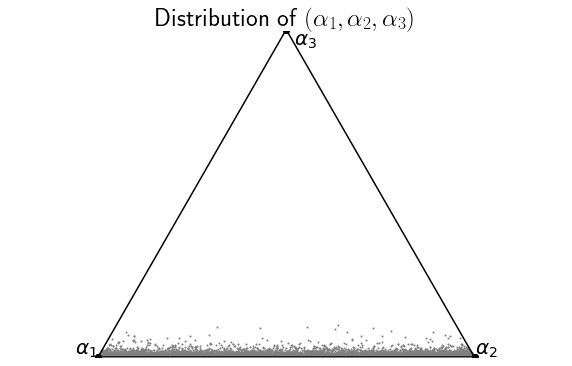

In [45]:
batch_idx = 19

alpha_1 = alpha_analysis.alpha_1.values
alpha_2 = alpha_analysis.alpha_2.values
alpha_3 = alpha_analysis.alpha_3.values
alpha = np.array([alpha_1[batch_idx],alpha_2[batch_idx],alpha_3[batch_idx]])
print(alpha)

sim_values = list(df_NBTS.query("batch_idx=={}".format(batch_idx)).groupby('parallel_idx').apply(lambda x: x.optimal_prob_nb.tolist()))

draw_sample_contours(Dirichlet(alpha), subdiv=4, samples=sim_values, alpha=0.8)

0.6979078173626004 0.699414559200715


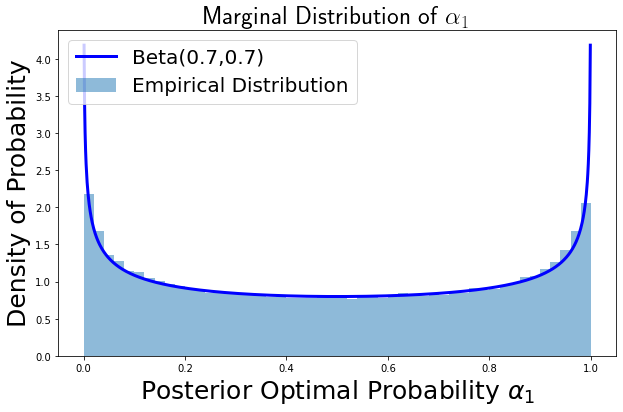

In [40]:
from scipy.stats import beta
# beta_a = alpha * (a0 - 2) + 1
beta_a = alpha[0]
beta_b = alpha[1]
print(beta_a, beta_b)

sim_values_0 = df_NBTS.query("arm_idx == 0 and batch_idx == {}".format(batch_idx)).optimal_prob_nb.values

plt.hist(sim_values_0, alpha=0.5, bins=50, density=True, label='Empirical Distribution');
x_values = np.linspace(0, 1, 1000)
plt.plot(x_values, beta.pdf(x_values, round(beta_a,1), round(beta_b, 1)), color='blue', alpha=1, lw=3, label=r'Beta({},{})'.format(round(beta_a,1), round(beta_b, 1)));

plt.title(r'Marginal Distribution of $\alpha_1$', fontsize=25, usetex = True);
plt.xlabel(r'Posterior Optimal Probability $\alpha_1$', fontsize=25);
plt.ylabel(r'Density of Probability', fontsize=25)
plt.legend(fontsize=20, loc='upper left')
# plt.legend(fontsize=20, loc='upper right')

# WBTS

In [18]:
G = 5000
beta = 0.5
tracking_history = []
for parallel_idx in range(n_parallels):
    bandit_choice = 0
    
    trials = [0 for i in range(K)]
    rewards = [0 for i in range(K)]
    mus_nb = [0 for i in range(K)]
    mus_wb = [0 for i in range(K)]
    lambdas = [0 for i in range(K)]
    numerator = [0 for i in range(K)]
    denominator = [0 for i in range(K)]
    batch_count = [0 for i in range(K)]
    # cal sample variance
    SS = [0 for _ in range(K)]
    sample_variance_nb = [1 for _ in range(K)]
    sample_variance_wb = [1 for _ in range(K)]
    sampling_probs = [1 / K for i in range(K)]
    for batch_idx in range(n_batches):
        batch_feedback = bandit.batch_observe_fast(
            sampling_distrib = sampling_probs, 
            time_index=batch_idx
        )
        for arm_idx in range(K):
            batch_trials = batch_feedback['trials'][arm_idx]
            if batch_trials > 0:
                trials[arm_idx] += batch_trials
                rewards[arm_idx] += batch_feedback['rewards'][arm_idx]
                # update batch info
                batch_count[arm_idx] += 1
                denominator[arm_idx] += np.sqrt(batch_trials)
                numerator[arm_idx] += batch_feedback['rewards'][arm_idx] / np.sqrt(batch_trials)
                # initial prior by first batch or update posterior
                lambdas[arm_idx] =  denominator[arm_idx]**2 / batch_count[arm_idx]
                mus_wb[arm_idx] = numerator[arm_idx] / denominator[arm_idx]
                mus_nb[arm_idx] = rewards[arm_idx] / trials[arm_idx]
                # cal sample variance
                SS[arm_idx] += batch_feedback['squared_rewards'][arm_idx]
                sample_variance_nb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_nb[arm_idx]**2
                sample_variance_wb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_wb[arm_idx]**2
        # weighted batched
        mc_sampling = np.array([np.random.normal(mus_wb[i], np.sqrt(sample_variance_wb[i]/(eta * lambdas[i])), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        wb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        wb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # naive batched
        mc_sampling = np.array([np.random.normal(mus_nb[i], np.sqrt(sample_variance_nb[i]/(eta * trials[i])), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        nb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        nb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # tracking history and analysis
        for arm_idx in range(K):
            tracking_reccord = (
                parallel_idx,
                null_vs_alter,
                batch_idx,
                arm_idx,
                sampling_probs[arm_idx],
                mus_nb[arm_idx],
                trials[arm_idx],
                sample_variance_nb[arm_idx],
                nb_optimal_probs[arm_idx],
                nb_posterior_delta[arm_idx],
                mus_wb[arm_idx],
                lambdas[arm_idx],
                sample_variance_wb[arm_idx],
                wb_optimal_probs[arm_idx],
                wb_posterior_delta[arm_idx],
                trials[arm_idx] / sum(trials)
            )
            tracking_history.append(tracking_reccord)
        # change traffic
        # optimal_odds = [wb_optimal_probs[i] / (1 - wb_optimal_probs[i]) if wb_optimal_probs[i] < 1 else 99 for i in range(K)]
        # sampling_probs = [wb_optimal_probs[i] * (beta + (1 - beta) * (np.sum(optimal_odds) - optimal_odds[i])) for i in range(K)]
        sampling_probs = [wb_optimal_probs[i] / np.sum(wb_optimal_probs) for i in range(K)]
        sampling_probs = [(1 - gamma) * sampling_probs[i] + gamma * 1/K for i in range(K)]
# convert tracking_history to dataframe
df_WBTS = pd.DataFrame(tracking_history, columns=[
    'parallel_idx','null_vs_alter','batch_idx', 'arm_idx', 'sampling_prob', 
    'mu_nb', 'tau_nb', 'sample_variance_nb', 'optimal_prob_nb','posterior_delta_nb',
    'mu_wb', 'tau_wb', 'sample_variance_wb', 'optimal_prob_wb','posterior_delta_wb',
    'proportion_trials'
])

In [19]:
alpha_analysis = df_WBTS.groupby(['null_vs_alter', 'batch_idx']).apply(
    lambda x: pd.Series([
        np.mean(x.optimal_prob_wb[x.arm_idx == 0]),
        np.var(x.optimal_prob_wb[x.arm_idx == 0]),
        np.mean(x.optimal_prob_wb[x.arm_idx == 1]),
        np.var(x.optimal_prob_wb[x.arm_idx == 1]),
        np.mean(x.optimal_prob_wb[x.arm_idx == 2]),
        np.var(x.optimal_prob_wb[x.arm_idx == 2]),
    ])
).rename(columns={
    0:'mean_prob_1',1:'var_prob_1',
    2:'mean_prob_2',3:'var_prob_2',
    4:'mean_prob_3',5:'var_prob_3',
}).reset_index()

alpha_analysis['alpha_0'] = alpha_analysis.mean_prob_1 * (1 - alpha_analysis.mean_prob_1) / alpha_analysis.var_prob_1 - 1
alpha_analysis['alpha_1'] = alpha_analysis.mean_prob_1 * alpha_analysis.alpha_0
alpha_analysis['alpha_2'] = alpha_analysis.mean_prob_2 * alpha_analysis.alpha_0
alpha_analysis['alpha_3'] = alpha_analysis.mean_prob_3 * alpha_analysis.alpha_0

alpha_analysis

null_vs_alter  batch_idx  mean_prob_1  var_prob_1  mean_prob_2  \
0               0          0     0.407430    0.082067     0.403348   
1               0          1     0.421967    0.075279     0.417503   
2               0          2     0.430737    0.074198     0.430405   
3               0          3     0.440270    0.074139     0.437494   
4               0          4     0.446175    0.074355     0.444168   
5               0          5     0.451388    0.074412     0.449825   
6               0          6     0.455715    0.074567     0.454129   
7               0          7     0.459431    0.075031     0.457855   
8               0          8     0.462674    0.075319     0.460724   
9               0          9     0.465041    0.075601     0.463703   
10              0         10     0.467228    0.075965     0.466335   
11              0         11     0.468992    0.076240     0.468739   
12              0         12     0.470851    0.076512     0.470668   
13              0         13     0.472919    0.076716     0.471996   
14              0         14     0.474573    0.076994     0.473447   
15              0         15     0.476553    0.077379     0.474240   
16              0         16     0.477681    0.077594     0.475565   
17              0         17     0.478702    0.077823     0.476787   
18              0         18     0.479540    0.077878     0.477902   
19              0         19     0.480640    0.078104     0.478692   

    var_prob_2  mean_prob_3  var_prob_3   alpha_0   alpha_1   alpha_2  \
0     0.081561     0.189223    0.045724  1.941891  0.791184  0.783257   
1     0.075269     0.160530    0.032252  2.240096  0.945247  0.935247   
2     0.074317     0.138859    0.024900  2.304709  0.992722  0.991957   
3     0.074162     0.122236    0.019966  2.323931  1.023157  1.016705   
4     0.074296     0.109657    0.016565  2.323300  1.036598  1.031936   
5     0.074372     0.098787    0.013754  2.327910  1.050791  1.047151   
6     0.074635     0.090156    0.011806  2.326368  1.060160  1.056472   
7     0.075024     0.082714    0.010223  2.310041  1.061303  1.057664   
8     0.075297     0.076603    0.008941  2.300723  1.064484  1.059997   
9     0.075426     0.071255    0.007909  2.290666  1.065254  1.062190   
10    0.075901     0.066437    0.006941  2.276851  1.063808  1.061775   
11    0.076168     0.062270    0.006229  2.266502  1.062971  1.062397   
12    0.076460     0.058481    0.005589  2.256362  1.062410  1.061997   
13    0.076652     0.055085    0.005044  2.249206  1.063692  1.061617   
14    0.076864     0.051980    0.004543  2.238613  1.062386  1.059864   
15    0.077259     0.049206    0.004120  2.223761  1.059741  1.054597   
16    0.077490     0.046755    0.003789  2.215497  1.058300  1.053612   
17    0.077759     0.044511    0.003468  2.206605  1.056306  1.052081   
18    0.077855     0.042559    0.003232  2.204772  1.057276  1.053664   
19    0.078014     0.040668    0.003005  2.196067  1.055517  1.051239   

     alpha_3  
0   0.367450  
1   0.359601  
2   0.320029  
3   0.284068  
4   0.254765  
5   0.229968  
6   0.209736  
7   0.191073  
8   0.176242  
9   0.163222  
10  0.151267  
11  0.141134  
12  0.131954  
13  0.123898  
14  0.116363  
15  0.109423  
16  0.103585  
17  0.098218  
18  0.093832  
19  0.089310

[1.05551732 1.05123916 0.08931012]


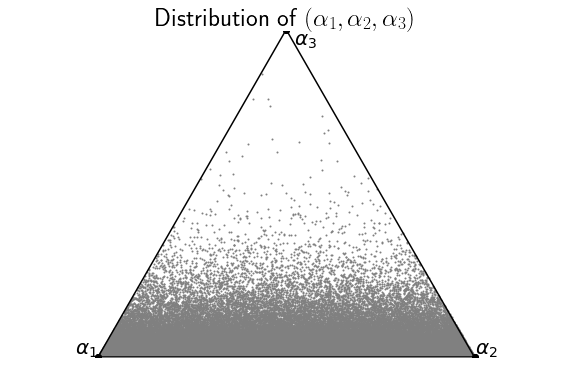

In [20]:
batch_idx = 19

alpha_1 = alpha_analysis.alpha_1.values
alpha_2 = alpha_analysis.alpha_2.values
alpha_3 = alpha_analysis.alpha_3.values
alpha = np.array([alpha_1[batch_idx],alpha_2[batch_idx],alpha_3[batch_idx]])
print(alpha)

sim_values = list(df_WBTS.query("batch_idx=={}".format(batch_idx)).groupby('parallel_idx').apply(lambda x: x.optimal_prob_wb.tolist()))

draw_sample_contours(Dirichlet(alpha), subdiv=4, samples=sim_values, alpha=0.8)

1.055517323377198 1.1405492768829983


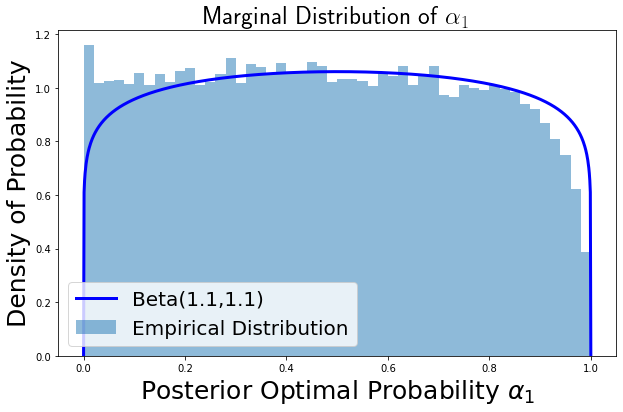

In [24]:
from scipy.stats import beta
# beta_a = alpha * (a0 - 2) + 1
beta_a = alpha[0]
beta_b = alpha[1]
print(beta_a, beta_b)

sim_values_0 = df_WBTS.query("arm_idx == 0 and batch_idx == {}".format(batch_idx)).optimal_prob_wb.values

plt.hist(sim_values_0, alpha=0.5, bins=50, density=True, label='Empirical Distribution');
x_values = np.linspace(0, 1, 1000)
plt.plot(x_values, beta.pdf(x_values, round(beta_a,1), round(beta_b, 1)), color='blue', alpha=1, lw=3, label=r'Beta({},{})'.format(round(beta_a,1), round(beta_b, 1)));

plt.title(r'Marginal Distribution of $\alpha_1$', fontsize=25, usetex = True);
plt.xlabel(r'Posterior Optimal Probability $\alpha_1$', fontsize=25);
plt.ylabel(r'Density of Probability', fontsize=25)
plt.legend(fontsize=20, loc='lower left')
# plt.legend(fontsize=20, loc='upper right')

# NBTTTS

In [25]:
G = 5000
beta = 0.5
tracking_history = []
for parallel_idx in range(n_parallels):
    null_vs_alter = 0

    trials = [0 for i in range(K)]
    rewards = [0 for i in range(K)]
    mus_nb = [0 for i in range(K)]
    mus_wb = [0 for i in range(K)]
    lambdas = [0 for i in range(K)]
    numerator = [0 for i in range(K)]
    denominator = [0 for i in range(K)]
    batch_count = [0 for i in range(K)]
    # cal sample variance
    SS = [0 for _ in range(K)]
    sample_variance_nb = [1 for _ in range(K)]
    sample_variance_wb = [1 for _ in range(K)]
    sampling_probs = [1 / K for i in range(K)]
    for batch_idx in range(n_batches):
        batch_feedback = bandit.batch_observe_fast(
            sampling_distrib = sampling_probs, 
            time_index=batch_idx
        )
        for arm_idx in range(K):
            batch_trials = batch_feedback['trials'][arm_idx]
            if batch_trials > 0:
                trials[arm_idx] += batch_trials
                rewards[arm_idx] += batch_feedback['rewards'][arm_idx]
                # update batch info
                batch_count[arm_idx] += 1
                denominator[arm_idx] += np.sqrt(batch_trials)
                numerator[arm_idx] += batch_feedback['rewards'][arm_idx] / np.sqrt(batch_trials)
                # initial prior by first batch or update posterior
                lambdas[arm_idx] =  denominator[arm_idx]**2 / batch_count[arm_idx]
                mus_wb[arm_idx] = numerator[arm_idx] / denominator[arm_idx]
                mus_nb[arm_idx] = rewards[arm_idx] / trials[arm_idx]
                # cal sample variance
                SS[arm_idx] += batch_feedback['squared_rewards'][arm_idx]
                sample_variance_nb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_nb[arm_idx]**2
                sample_variance_wb[arm_idx] = SS[arm_idx] / trials[arm_idx] - mus_wb[arm_idx]**2
        # weighted batched
        mc_sampling = np.array([np.random.normal(mus_wb[i], np.sqrt(sample_variance_wb[i]/(eta * lambdas[i])), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        wb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        wb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # naive batched
        mc_sampling = np.array([np.random.normal(mus_nb[i], np.sqrt(sample_variance_nb[i]/(eta * trials[i])), G) for i in range(K)])
        mc_optimal_arm = np.argmax(mc_sampling, axis=0)
        nb_posterior_delta = np.mean(np.max(mc_sampling, axis=0) - mc_sampling, axis=1)
        nb_optimal_probs = [round(np.sum(np.where(mc_optimal_arm == arm_i, 1, 0)) / G, 4) for arm_i in range(K)]
        # tracking history and analysis
        for arm_idx in range(K):
            tracking_reccord = (
                parallel_idx,
                null_vs_alter,
                batch_idx,
                arm_idx,
                sampling_probs[arm_idx],
                mus_nb[arm_idx],
                trials[arm_idx],
                sample_variance_nb[arm_idx],
                nb_optimal_probs[arm_idx],
                nb_posterior_delta[arm_idx],
                mus_wb[arm_idx],
                lambdas[arm_idx],
                sample_variance_wb[arm_idx],
                wb_optimal_probs[arm_idx],
                wb_posterior_delta[arm_idx],
                trials[arm_idx] / sum(trials)
            )
            tracking_history.append(tracking_reccord)
        # change traffic
        optimal_odds = [nb_optimal_probs[i] / (1 - nb_optimal_probs[i]) if nb_optimal_probs[i] < 1 else 99 for i in range(K)]
        sampling_probs = [nb_optimal_probs[i] * (beta + (1 - beta) * (np.sum(optimal_odds) - optimal_odds[i])) for i in range(K)]
        sampling_probs = [sampling_probs[i] / np.sum(sampling_probs) for i in range(K)]
        sampling_probs = [(1 - gamma) * sampling_probs[i] + gamma * 1/K for i in range(K)]
# convert tracking_history to dataframe
df_NBTTTS = pd.DataFrame(tracking_history, columns=[
    'parallel_idx','null_vs_alter','batch_idx', 'arm_idx', 'sampling_prob', 
    'mu_nb', 'tau_nb', 'sample_variance_nb', 'optimal_prob_nb','posterior_delta_nb',
    'mu_wb', 'tau_wb', 'sample_variance_wb', 'optimal_prob_wb','posterior_delta_wb',
    'proportion_trials'
])

In [26]:
alpha_analysis = df_NBTTTS.groupby(['null_vs_alter', 'batch_idx']).apply(
    lambda x: pd.Series([
        np.mean(x.optimal_prob_nb[x.arm_idx == 0]),
        np.var(x.optimal_prob_nb[x.arm_idx == 0]),
        np.mean(x.optimal_prob_nb[x.arm_idx == 1]),
        np.var(x.optimal_prob_nb[x.arm_idx == 1]),
        np.mean(x.optimal_prob_nb[x.arm_idx == 2]),
        np.var(x.optimal_prob_nb[x.arm_idx == 2]),
    ])
).rename(columns={
    0:'mean_prob_1',1:'var_prob_1',
    2:'mean_prob_2',3:'var_prob_2',
    4:'mean_prob_3',5:'var_prob_3',
}).reset_index()

alpha_analysis['alpha_0'] = alpha_analysis.mean_prob_1 * (1 - alpha_analysis.mean_prob_1) / alpha_analysis.var_prob_1 - 1
alpha_analysis['alpha_1'] = alpha_analysis.mean_prob_1 * alpha_analysis.alpha_0
alpha_analysis['alpha_2'] = alpha_analysis.mean_prob_2 * alpha_analysis.alpha_0
alpha_analysis['alpha_3'] = alpha_analysis.mean_prob_3 * alpha_analysis.alpha_0

alpha_analysis

null_vs_alter  batch_idx  mean_prob_1  var_prob_1  mean_prob_2  \
0               0          0     0.405633    0.082841     0.404287   
1               0          1     0.428085    0.084021     0.427984   
2               0          2     0.443421    0.085204     0.441646   
3               0          3     0.453176    0.086004     0.451879   
4               0          4     0.461139    0.086610     0.458965   
5               0          5     0.466972    0.087154     0.464863   
6               0          6     0.471078    0.087381     0.469704   
7               0          7     0.474242    0.087165     0.473944   
8               0          8     0.477260    0.087014     0.476899   
9               0          9     0.479973    0.086911     0.479293   
10              0         10     0.482404    0.086681     0.481060   
11              0         11     0.484021    0.086542     0.483034   
12              0         12     0.485750    0.086385     0.484340   
13              0         13     0.487131    0.086287     0.485645   
14              0         14     0.488064    0.086189     0.486937   
15              0         15     0.489037    0.086072     0.487953   
16              0         16     0.490155    0.085948     0.488556   
17              0         17     0.490569    0.085731     0.489620   
18              0         18     0.491235    0.085615     0.490394   
19              0         19     0.491970    0.085452     0.490928   

    var_prob_2  mean_prob_3  var_prob_3   alpha_0   alpha_1   alpha_2  \
0     0.082522     0.190080    0.046676  1.910348  0.774901  0.772329   
1     0.083732     0.143932    0.032572  1.913903  0.819313  0.819119   
2     0.085019     0.114933    0.024316  1.896562  0.840975  0.837609   
3     0.086030     0.094945    0.018781  1.881361  0.852588  0.850148   
4     0.086462     0.079896    0.014642  1.869057  0.861896  0.857832   
5     0.087039     0.068164    0.011662  1.855960  0.866682  0.862768   
6     0.087284     0.059218    0.009534  1.851458  0.872182  0.869637   
7     0.087168     0.051814    0.007823  1.860502  0.882329  0.881774   
8     0.087132     0.045840    0.006431  1.867157  0.891120  0.890446   
9     0.086950     0.040735    0.005290  1.871897  0.898460  0.897186   
10    0.086597     0.036536    0.004415  1.880566  0.907193  0.904664   
11    0.086596     0.032945    0.003699  1.885834  0.912784  0.910922   
12    0.086474     0.029910    0.003126  1.891659  0.918873  0.916206   
13    0.086357     0.027224    0.002683  1.895387  0.923301  0.920486   
14    0.086206     0.024999    0.002322  1.898952  0.926811  0.924671   
15    0.086127     0.023010    0.002020  1.903135  0.930704  0.928640   
16    0.085989     0.021288    0.001772  1.907599  0.935019  0.931970   
17    0.085764     0.019812    0.001543  1.915061  0.939469  0.937652   
18    0.085628     0.018371    0.001349  1.919141  0.942750  0.941135   
19    0.085449     0.017102    0.001159  1.924858  0.946973  0.944966   

     alpha_3  
0   0.363119  
1   0.275471  
2   0.217978  
3   0.178625  
4   0.149330  
5   0.126510  
6   0.109639  
7   0.096399  
8   0.085591  
9   0.076251  
10  0.068709  
11  0.062128  
12  0.056580  
13  0.051600  
14  0.047471  
15  0.043791  
16  0.040610  
17  0.037941  
18  0.035256  
19  0.032919

[0.94697338 0.94496605 0.03291878]


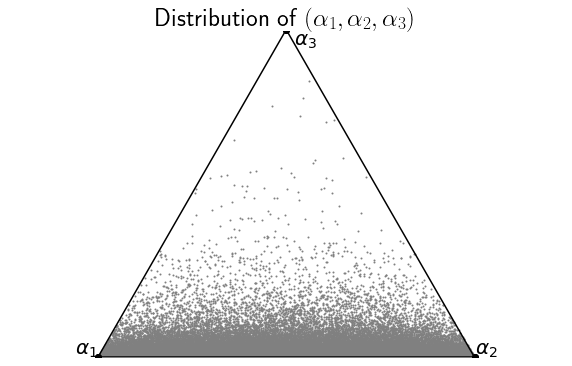

In [27]:
batch_idx = 19

alpha_1 = alpha_analysis.alpha_1.values
alpha_2 = alpha_analysis.alpha_2.values
alpha_3 = alpha_analysis.alpha_3.values
alpha = np.array([alpha_1[batch_idx],alpha_2[batch_idx],alpha_3[batch_idx]])
print(alpha)

sim_values = list(df_NBTTTS.query("batch_idx=={}".format(batch_idx)).groupby('parallel_idx').apply(lambda x: x.optimal_prob_nb.tolist()))

draw_sample_contours(Dirichlet(alpha), subdiv=4, samples=sim_values, alpha=0.8)

0.9469733815868409 0.9449660547462261


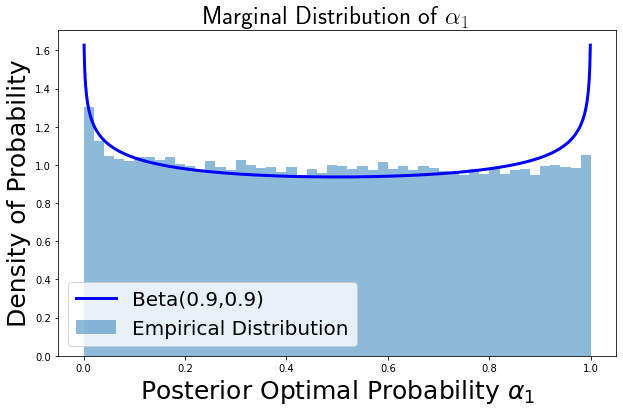

In [28]:
from scipy.stats import beta
# beta_a = alpha * (a0 - 2) + 1
beta_a = alpha[0]
beta_b = alpha[1]
print(beta_a, beta_b)

sim_values_0 = df_NBTTTS.query("arm_idx == 0 and batch_idx == {}".format(batch_idx)).optimal_prob_nb.values

plt.hist(sim_values_0, alpha=0.5, bins=50, density=True, label='Empirical Distribution');
x_values = np.linspace(0, 1, 1000)
plt.plot(x_values, beta.pdf(x_values, round(beta_a,1), round(beta_b, 1)), color='blue', alpha=1, lw=3, label=r'Beta({},{})'.format(round(beta_a,1), round(beta_b, 1)));

plt.title(r'Marginal Distribution of $\alpha_1$', fontsize=25, usetex = True);
plt.xlabel(r'Posterior Optimal Probability $\alpha_1$', fontsize=25);
plt.ylabel(r'Density of Probability', fontsize=25)
plt.legend(fontsize=20, loc='lower left')
# plt.legend(fontsize=20, loc='upper right')